# Tutorial: optimal binning sketch with binary target

## Stream processing

To get us started, let's prepare the application_train.csv file from the Kaggle's competition https://www.kaggle.com/c/home-credit-default-risk/data. This dataset will be used to simulate streaming data.

In [1]:
import pandas as pd

In [2]:
filepath = "data/kaggle/HomeCreditDefaultRisk/application_train.csv"

We choose a variable to discretize and the binary target.

In [3]:
variable = "EXT_SOURCE_2"
target = "TARGET"

Import and instantiate an ``OptimalBinningSketch`` object class. We pass the variable name, its data type, and a solver, in this case, we choose the constraint programming solver. In addition, we pass the binning sketch type and the desired absolute precision.

In [4]:
from optbinning import OptimalBinningSketch

In [5]:
optbsketch = OptimalBinningSketch(name=variable, dtype="numerical", sketch="gk",
                                  eps=1e-4, min_bin_size=0.05, solver="cp")

For simulating data streams, we read by chunks the dataset, adding arrays ``x`` and ``y`` of length 1000 to the optimal binning sketch object. If ``chunksize=1``, we would add one single record at a time. Besides, we perform a solve every 10 additions to keep progress of the optimal binning sketch performance.

In [6]:
chunks = pd.read_csv(filepath_or_buffer=filepath, engine='c', chunksize=1000,
                     usecols=[variable, target])

for k, chunk in enumerate(chunks):
    x = chunk[variable].values
    y = chunk[target].values
    
    optbsketch.add(x, y)
    
    if k % 10 == 0:
        optbsketch.solve()

In [7]:
optbsketch.solve()

OptimalBinningSketch(K=25, cat_cutoff=None, cat_heuristic=False,
                     divergence='iv', dtype='numerical', eps=0.0001, gamma=0,
                     max_bin_n_event=None, max_bin_n_nonevent=None,
                     max_bin_size=None, max_n_bins=None, max_n_prebins=20,
                     max_pvalue=None, max_pvalue_policy='consecutive',
                     min_bin_n_event=None, min_bin_n_nonevent=None,
                     min_bin_size=0.05, min_event_rate_diff=0, min_n_bins=None,
                     mip_solver='bop', monotonic_trend='auto',
                     name='EXT_SOURCE_2', sketch='gk', solver='cp',
                     special_codes=None, split_digits=None, time_limit=100,
                     verbose=False)

You can check if an optimal solution has been found via the ``status`` attribute:

In [8]:
optbsketch.status

'OPTIMAL'

You can also retrieve the optimal split points via the ``splits`` attribute:

In [9]:
optbsketch.splits

array([0.21604822, 0.33976279, 0.39249913, 0.47915776, 0.56599903,
       0.60839573, 0.64593877, 0.68204983, 0.72210817])

As in other binning classes in this library, method ``information`` is available to display overview information. This includes streaming statistics and timings such as the time spent in additions and solves, or the memory usage of the internal binning sketch. Note that the total time migth be significantly higher due to the time spent by pandas reading the CSV file. The remaining information is corresponding to the last solution.

In [10]:
optbsketch.information(print_level=2)

optbinning (Version 0.6.1)
Copyright (c) 2019-2020 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    name                        EXT_SOURCE_2   * U
    dtype                          numerical   * d
    sketch                                gk   * d
    eps                               0.0001   * d
    K                                     25   * d
    solver                                cp   * d
    divergence                            iv   * d
    max_n_prebins                         20   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                        0.05   * U
    max_bin_size                          no   * d
    min_bin_n_nonevent                    no   * d
    max_bin_n_nonevent                    no   * d
    min_bin_n_event                       no   * d
    max_bin_n_event                       no   * d
    monotonic_trend                     auto   * d
    min_event_rate_d

Since we have performed several solves throughout the process, we can observe the performance progress using method  ``plot_progress``. Observe the convergence and reduction of the standard error as new data is added.

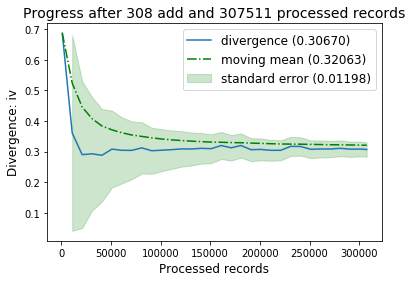

In [11]:
optbsketch.plot_progress()

##### The binning table

The optimal binning algorithms return a binning table; a binning table displays the binned data and several metrics for each bin. Class ``OptimalBinningSketch`` returns an object ``BinningTable`` via the ``binning_table`` attribute.

In [12]:
optbsketch.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 0.22)",30728,0.099925,25095,5633,0.183318,-0.938459,0.129634,1.563463e-02
1,"[0.22, 0.34)",30609,0.099538,26905,3704,0.121010,-0.449587,0.024290,3.010977e-03
2,"[0.34, 0.39)",15387,0.050037,13761,1626,0.105674,-0.29677,0.004991,6.216437e-04
3,"[0.39, 0.48)",30719,0.099896,27945,2774,0.090302,-0.122538,0.001579,1.972682e-04
4,"[0.48, 0.57)",46028,0.149679,42524,3504,0.076128,0.0636779,0.000591,7.385673e-05
5,"[0.57, 0.61)",30682,0.099775,28642,2040,0.066488,0.209439,0.004010,5.003169e-04
6,"[0.61, 0.65)",30692,0.099808,28898,1794,0.058452,0.346839,0.010392,1.292468e-03
7,"[0.65, 0.68)",30612,0.099548,29116,1496,0.048870,0.536007,0.022907,2.829549e-03
8,"[0.68, 0.72)",30747,0.099987,29458,1289,0.041923,0.696613,0.036422,4.462842e-03
9,"[0.72, inf)",30647,0.099661,29734,913,0.029791,1.05083,0.071883,8.593536e-03


You can use the method ``plot`` to visualize the histogram and WoE or event rate curve. Note that the Bin ID corresponds to the binning table index.

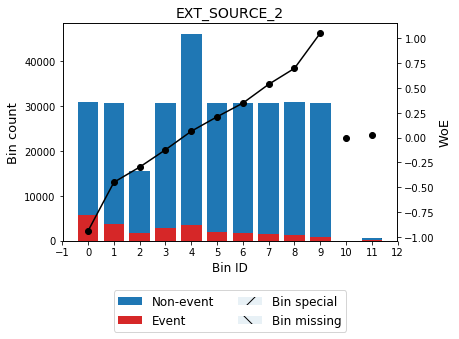

In [13]:
optbsketch.binning_table.plot(metric="woe")

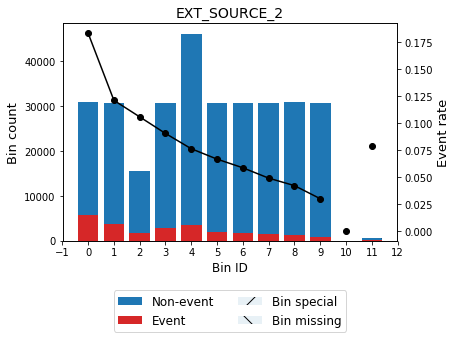

In [14]:
optbsketch.binning_table.plot(metric="event_rate")

##### Event rate / WoE transformation

Now that we have checked the binned data, we can transform our original data into WoE or event rate values. You can check the correctness of the transformation using pandas ``value_counts`` method, for instance. The ``transform`` method is handy to transform streaming data with the current binning sketch or after the fitting of the binning sketch has been completed.

In [15]:
x = [0.2, 0.31, 0.21, 0.12, 0.16, 0.41, 0.65, 0.8]

In [16]:
x_transform_woe = optbsketch.transform(x, metric="woe")

In [17]:
pd.Series(x_transform_woe).value_counts()

-0.938459    4
-0.122538    1
-0.449587    1
 1.050825    1
 0.536007    1
dtype: int64

In [18]:
x_transform_event_rate = optbsketch.transform(x, metric="event_rate")

In [19]:
pd.Series(x_transform_event_rate).value_counts()

0.183318    4
0.048870    1
0.029791    1
0.121010    1
0.090302    1
dtype: int64

In [20]:
x_transform_indices = optbsketch.transform(x, metric="indices")

In [21]:
pd.Series(x_transform_indices).value_counts()

0    4
7    1
3    1
9    1
1    1
dtype: int64

In [22]:
x_transform_bins = optbsketch.transform(x, metric="bins")

In [23]:
pd.Series(x_transform_bins).value_counts()

[-inf, 0.22)    4
[0.65, 0.68)    1
[0.22, 0.34)    1
[0.72, inf)     1
[0.39, 0.48)    1
dtype: int64

#### Categorical variable

In [24]:
variable_cat = "NAME_INCOME_TYPE"

We instantiate an ``OptimalBinningSketch`` object class with the variable name, its data type (**categorical**) and a solver, in this case, we choose the mixed-integer programming solver. Also, for this particular example, we set a ``cat_cutoff=0.1`` to create bin others with categories in which the percentage of occurrences is below 10%. This will merge categories State servant, Unemployed, Student, Businessman and Maternity leave.

In [25]:
optbsketch = OptimalBinningSketch(name=variable_cat, dtype="categorical", solver="mip",
                                  min_bin_size=0.05, cat_cutoff=0.1)

Similar to the previous case, we simulate streaming data and perform several solves throughout the process.

In [26]:
chunks = pd.read_csv(filepath_or_buffer=filepath, engine='c', chunksize=100,
                     usecols=[variable_cat, target])

for k, chunk in enumerate(chunks):
    x = chunk[variable_cat].values
    y = chunk[target].values
    
    optbsketch.add(x, y)
    
    if k % 100 == 0:
        optbsketch.solve()

In [27]:
optbsketch.solve()

OptimalBinningSketch(K=25, cat_cutoff=0.1, cat_heuristic=False, divergence='iv',
                     dtype='categorical', eps=0.0001, gamma=0,
                     max_bin_n_event=None, max_bin_n_nonevent=None,
                     max_bin_size=None, max_n_bins=None, max_n_prebins=20,
                     max_pvalue=None, max_pvalue_policy='consecutive',
                     min_bin_n_event=None, min_bin_n_nonevent=None,
                     min_bin_size=0.05, min_event_rate_diff=0, min_n_bins=None,
                     mip_solver='bop', monotonic_trend='auto',
                     name='NAME_INCOME_TYPE', sketch='gk', solver='mip',
                     special_codes=None, split_digits=None, time_limit=100,
                     verbose=False)

In [28]:
optbsketch.status

'OPTIMAL'

The optimal split points are the list of classes belonging to each bin.

In [29]:
optbsketch.splits

[array(['Pensioner'], dtype=object),
 array(['Commercial associate'], dtype=object),
 array(['Working'], dtype=object),
 array(['State servant', 'Unemployed', 'Student', 'Businessman',
        'Maternity leave'], dtype=object)]

Note that for categorical data, the time per add and memory usage is significantly reduced.

In [30]:
optbsketch.information(print_level=2)

optbinning (Version 0.6.1)
Copyright (c) 2019-2020 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    name                     NAME_INCOME_TYPE   * U
    dtype                        categorical   * U
    sketch                                gk   * d
    eps                               0.0001   * d
    K                                     25   * d
    solver                               mip   * U
    divergence                            iv   * d
    max_n_prebins                         20   * d
    min_n_bins                            no   * d
    max_n_bins                            no   * d
    min_bin_size                        0.05   * U
    max_bin_size                          no   * d
    min_bin_n_nonevent                    no   * d
    max_bin_n_nonevent                    no   * d
    min_bin_n_event                       no   * d
    max_bin_n_event                       no   * d
    monotonic_trend                     auto   * d
    min_event_rate_

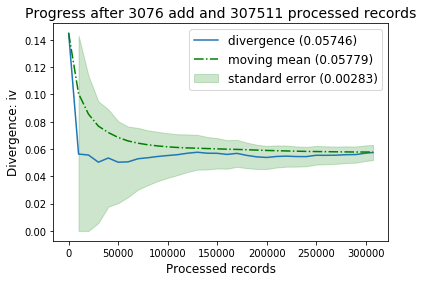

In [31]:
optbsketch.plot_progress()

In [32]:
optbsketch.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Pensioner],55362,0.180033,52380,2982,0.053864,0.433445,0.028249,0.003504
1,[Commercial associate],71617,0.232892,66257,5360,0.074843,0.0820916,0.001516,0.000189
2,[Working],158774,0.516320,143550,15224,0.095885,-0.188675,0.019895,0.002483
3,"[State servant, Unemployed, Student, Businessm...",21758,0.070755,20499,1259,0.057864,0.357573,0.007795,0.000969
4,Special,0,0.000000,0,0,0.000000,0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0,0.000000,0.000000
Totals,,307511,1.000000,282686,24825,0.080729,,0.057455,0.007146


You can use the method ``plot`` to visualize the histogram and WoE or event rate curve. Note that for categorical variables the optimal bins are **always** monotonically ascending with respect to the event rate. Finally, note that bin 3 corresponds to bin others and is represented by using a lighter color.

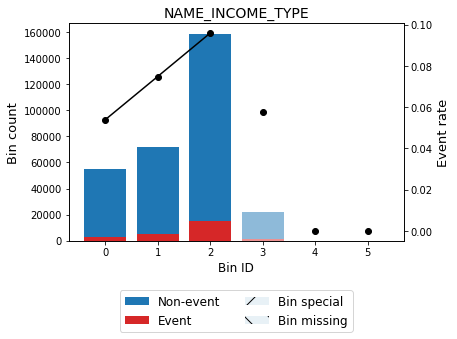

In [33]:
optbsketch.binning_table.plot(metric="event_rate")

Same as for the numerical dtype, we can transform our original data into WoE or event rate values. Transformation of data including categories not present during training return zero WoE or event rate.

In [34]:
x_new = ["Businessman", "Working", "Unknown"]

In [35]:
x_transform_woe = optbsketch.transform(x_new, metric="woe")

In [36]:
pd.DataFrame({variable_cat: x_new, "WoE": x_transform_woe})

,NAME_INCOME_TYPE,WoE
0,Businessman,0.357573
1,Working,-0.188675
2,Unknown,0.000000


## Batch processing

The new OptimalBinningSketch class permits several new use cases:

- **Case 1**: Optimal binning using datasets with the same structure stored on a distributed infrastructure. **No data centralization**.

- **Case 2**: Optimal binning for very large datasets that do not fit in memory.

- **Case 3**: Optimal binning suitable for **federated learning**. The training data is kept on the device, only the OptimalBinningSketch class is sent to the cloud, where it is merged.


In this example, we have three partitions of a dataset. For faster columnar access we use parquet

In [37]:
filepaths = ["data/df1.parquet.gzip",
             "data/df2.parquet.gzip",
             "data/df3.parquet.gzip"]

In [38]:
variable = "EXT_SOURCE_3"
target = "TARGET"

We create a simple map-reduce structure

In [39]:
from functools import reduce

In [40]:
def add(filepath):
    df = pd.read_parquet(path=filepath, columns=[variable, target])
    x = df[variable].values
    y = df[target].values
   
    optbsketch = OptimalBinningSketch(name=variable, dtype="numerical",
                                      sketch="gk", min_bin_size=0.05)
    optbsketch.add(x, y)
    
    return optbsketch
    
def merge(optbsketch, other_optbsketch):
    optbsketch.merge(other_optbsketch)
    
    return optbsketch


optbsketch = reduce(merge, map(add, filepaths))

In [41]:
optbsketch.solve()

OptimalBinningSketch(K=25, cat_cutoff=None, cat_heuristic=False,
                     divergence='iv', dtype='numerical', eps=0.0001, gamma=0,
                     max_bin_n_event=None, max_bin_n_nonevent=None,
                     max_bin_size=None, max_n_bins=None, max_n_prebins=20,
                     max_pvalue=None, max_pvalue_policy='consecutive',
                     min_bin_n_event=None, min_bin_n_nonevent=None,
                     min_bin_size=0.05, min_event_rate_diff=0, min_n_bins=None,
                     mip_solver='bop', monotonic_trend='auto',
                     name='EXT_SOURCE_3', sketch='gk', solver='cp',
                     special_codes=None, split_digits=None, time_limit=100,
                     verbose=False)

In [42]:
optbsketch.information()

optbinning (Version 0.6.1)
Copyright (c) 2019-2020 Guillermo Navas-Palencia, Apache License 2.0

  Name    : EXT_SOURCE_3                    
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of pre-bins                    20
    Number of refinements                  0

  Solver statistics
    Type                                  cp
    Number of booleans                   121
    Number of branches                   252
    Number of conflicts                    0
    Objective value                   411345
    Best objective bound              411345

  Timing
    Total time                          0.70 sec
    Pre-binning                         0.44 sec   ( 62.69%)
    Solver                              0.26 sec   ( 37.30%)
      model generation                  0.22 sec   ( 84.15%)
      optimizer                         0.04 sec   ( 15.85%)
    Post-processing                     0.00 sec   (  0.01%)

  Streaming statistics
    Sketch memory 

In [43]:
optbsketch.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[-inf, 0.23)",24912,0.081012,19934,4978,0.199823,-1.04509,0.135869,0.016251
1,"[0.23, 0.33)",24475,0.079591,21357,3118,0.127395,-0.508298,0.025440,0.003146
2,"[0.33, 0.41)",25058,0.081487,22675,2383,0.095099,-0.179583,0.002834,0.000354
3,"[0.41, 0.48)",24687,0.080280,22718,1969,0.079759,0.0131462,0.000014,0.000002
4,"[0.48, 0.56)",36860,0.119866,34644,2216,0.060119,0.316935,0.010550,0.001313
5,"[0.56, 0.62)",24858,0.080836,23606,1252,0.050366,0.504273,0.016678,0.002063
6,"[0.62, 0.67)",24647,0.080150,23565,1082,0.043900,0.648466,0.025793,0.003169
7,"[0.67, 0.72)",24067,0.078264,23128,939,0.039016,0.771498,0.033939,0.004140
8,"[0.72, inf)",36982,0.120262,35771,1211,0.032746,0.953206,0.074120,0.008929
9,Special,0,0.000000,0,0,0.000000,0,0.000000,0.000000


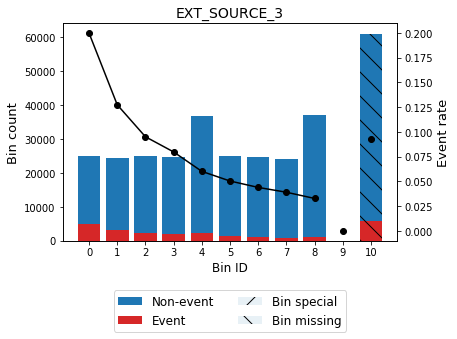

In [44]:
optbsketch.binning_table.plot(metric="event_rate")

In [45]:
optbsketch.binning_table.analysis()

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.31382475
    IV (Jeffrey)             0.33041081
    JS (Jensen-Shannon)      0.04001304
    Hellinger                0.04064260
    Triangular               0.15533757
    HHI                      0.11320133
    HHI (normalized)         0.02452146
    Cramer's V               0.18562733
    Quality score            0.94042182

  Significance tests

     Bin A  Bin B  t-statistic        p-value  P[A > B]      P[B > A]
         0      1   472.532789  9.007791e-105  1.000000  1.110223e-16
         1      2   130.812523   2.721311e-30  1.000000  1.110223e-16
         2      3    36.659113   1.406997e-09  1.000000  7.681522e-12
         3      4    89.982629   2.402603e-21  1.000000  1.110223e-16
         4      5    26.629360   2.464697e-07  1.000000  1.861165e-09
         5      6    11.518699   6.8899